### Paritioning Comparison for different models

In [1]:
import numpy as np
import pandas as pd
import os 
import sys
import itertools
import time
import matplotlib.pyplot as plt

In [2]:
# Set Helvetica font and IEEE style parameters
plt.rcParams.update({
        'font.family': 'sans-serif',
        'font.sans-serif': ['Helvetica', 'Arial'],
        'font.size': 8,
        'axes.labelsize': 9,
        'axes.titlesize': 9,
        'xtick.labelsize': 8,
        'ytick.labelsize': 8,
        'legend.fontsize': 7,
        'figure.titlesize': 10,
        'axes.linewidth': 0.8,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.5,
        'xtick.major.width': 0.8,
        'ytick.major.width': 0.8,
        'xtick.direction': 'in',
        'ytick.direction': 'in',
    })

In [3]:
"""
Load and combine mapping comparison data for all models.

For each model:
- Loads mapping_comparison_{model_name}.csv (row_wise, column_wise)
- Loads random_mapping_comparison_{model_name}.csv (random mapping with multiple runs)
- Averages the random mapping results
- Combines all three strategies (row_wise, column_wise, random_avg) into a single dataframe
"""

import glob

# Directory containing the CSV files
data_dir = '../data/mapping_comparison'

# Find all unique model names
mapping_files = glob.glob(f'{data_dir}/mapping_comparison_*.csv')
model_names = [f.replace(f'{data_dir}/mapping_comparison_', '').replace('.csv', '') for f in mapping_files]
model_names = sorted(model_names)

print(f"Found {len(model_names)} models:")
for model in model_names:
    print(f"  - {model}")

# Dictionary to store dataframes for each model
model_dataframes = {}

for model_name in model_names:
    print(f"\n{'='*80}")
    print(f"Processing: {model_name}")
    print(f"{'='*80}")
    
    # Load deterministic mappings (row_wise, column_wise)
    mapping_file = f'{data_dir}/mapping_comparison_{model_name}.csv'
    df_mapping = pd.read_csv(mapping_file)
    print(f"✓ Loaded {mapping_file}: {len(df_mapping)} rows")
    print(f"  Strategies: {df_mapping['mapping_strategy'].unique()}")
    
    # Load random mappings (multiple runs to average)
    random_file = f'{data_dir}/random_mapping_comparison_{model_name}.csv'
    try:
        df_random = pd.read_csv(random_file)
        print(f"✓ Loaded {random_file}: {len(df_random)} rows")
        
        # Average the random mapping results
        # Group by all columns except result_analytical and analytical_time
        group_cols = ['mapping_strategy', 'num_partitions', 'parts_per_layer', 'total_tasks', 'partitioner_config']
        df_random_avg = df_random.groupby(group_cols, as_index=False).agg({
            'result_analytical': 'mean',
            'analytical_time': 'mean'
        })
        
        print(f"  Random runs: {len(df_random)} → averaged to {len(df_random_avg)} rows")
        print(f"  Average result_analytical: {df_random_avg['result_analytical'].iloc[0]:.0f} cycles")
        
        # Combine all strategies
        df_combined = pd.concat([df_mapping, df_random_avg], ignore_index=True)
        
    except FileNotFoundError:
        print(f"✗ No random mapping file found: {random_file}")
        print(f"  Using only deterministic mappings")
        df_combined = df_mapping.copy()
    
    # Store in dictionary
    model_dataframes[model_name] = df_combined
    
    print(f"\nCombined dataframe for {model_name}:")
    print(f"  Total rows: {len(df_combined)}")
    print(f"  Strategies: {df_combined['mapping_strategy'].unique()}")
    print(f"  Columns: {list(df_combined.columns)}")

print(f"\n{'='*80}")
print(f"Summary: Loaded {len(model_dataframes)} models")
print(f"{'='*80}")

Found 8 models:
  - AlexNet
  - MobileNetv1
  - ResNet32
  - ResNet32_early
  - ResNet32_late
  - ResNet32_mid
  - VGG16_early
  - VGG16_late

Processing: AlexNet
✓ Loaded ../data/mapping_comparison/mapping_comparison_AlexNet.csv: 2 rows
  Strategies: ['row_wise' 'column_wise']
✓ Loaded ../data/mapping_comparison/random_mapping_comparison_AlexNet.csv: 11 rows
  Random runs: 11 → averaged to 1 rows
  Average result_analytical: 5177056 cycles

Combined dataframe for AlexNet:
  Total rows: 3
  Strategies: ['row_wise' 'column_wise' 'random']
  Columns: ['mapping_strategy', 'num_partitions', 'parts_per_layer', 'total_tasks', 'result_analytical', 'analytical_time', 'partitioner_config']

Processing: MobileNetv1
✓ Loaded ../data/mapping_comparison/mapping_comparison_MobileNetv1.csv: 2 rows
  Strategies: ['row_wise' 'column_wise']
✓ Loaded ../data/mapping_comparison/random_mapping_comparison_MobileNetv1.csv: 11 rows
  Random runs: 11 → averaged to 1 rows
  Average result_analytical: 609231 cyc

In [4]:
model_dataframes['AlexNet']

,mapping_strategy,num_partitions,parts_per_layer,total_tasks,result_analytical,analytical_time,partitioner_config
0,row_wise,1321,120,1274,1.315811e+06,104.8386,"(2, 6, 5)"
1,column_wise,1321,120,1274,1.315832e+06,107.7931,"(2, 6, 5)"
2,random,1321,120,1274,5.177056e+06,107.0556,"(2, 6, 5)"


In [5]:
model_dataframes['MobileNetv1']

,mapping_strategy,num_partitions,parts_per_layer,total_tasks,result_analytical,analytical_time,partitioner_config
0,row_wise,541,20,534,359175.000000,23.393600,"(0, 4, 5)"
1,column_wise,541,20,534,356366.000000,32.521400,"(0, 4, 5)"
2,random,541,20,534,609231.363636,43.897618,"(0, 4, 5)"


In [ ]:
model_dataframes['ResNet32_early']

In [ ]:
model_dataframes['ResNet32_mid']

In [ ]:
model_dataframes['ResNet32_late']

In [34]:
"""
Normalize the results for each model to the random mapping baseline.

For each model:
- Extract the random mapping latency as the baseline (= 1.0)
- Normalize all strategies (row_wise, column_wise, random) relative to this baseline
- Create normalized dataframe with a new column 'result_normalized'
"""

model_dataframes_normalised = {}

print(f"{'='*80}")
print(f"Normalizing results to random mapping baseline")
print(f"{'='*80}")

for model_name, df in model_dataframes.items():
    print(f"\nProcessing: {model_name}")
    
    # Get random mapping latency as baseline
    random_row = df[df['mapping_strategy'] == 'random']
    
    if len(random_row) > 0:
        baseline = random_row['result_analytical'].values[0]
        print(f"  Random baseline: {baseline:,.0f} cycles")
        
        # Create a copy and add normalized column
        df_normalized = df.copy()
        df_normalized['result_normalized'] = df_normalized['result_analytical'] / baseline
        
        # Store normalized dataframe
        model_dataframes_normalised[model_name] = df_normalized
        
        print(f"  Normalized values:")
        for _, row in df_normalized.iterrows():
            print(f"    {row['mapping_strategy']:12s}: {row['result_normalized']:.4f} "
                  f"({row['result_analytical']:>12,.0f} cycles)")
    else:
        print(f"  ✗ No random mapping found - skipping normalization")
        # Keep original dataframe without normalization
        model_dataframes_normalised[model_name] = df.copy()

print(f"\n{'='*80}")
print(f"Summary: Normalized {len(model_dataframes_normalised)} models")
print(f"{'='*80}")

Normalizing results to random mapping baseline

Processing: AlexNet
  Random baseline: 5,177,056 cycles
  Normalized values:
    row_wise    : 0.2542 (   1,315,811 cycles)
    column_wise : 0.2542 (   1,315,832 cycles)
    random      : 1.0000 (   5,177,056 cycles)

Processing: MobileNetv1
  Random baseline: 609,231 cycles
  Normalized values:
    row_wise    : 0.5896 (     359,175 cycles)
    column_wise : 0.5849 (     356,366 cycles)
    random      : 1.0000 (     609,231 cycles)

Processing: ResNet32
  ✗ No random mapping found - skipping normalization

Processing: ResNet32_early
  Random baseline: 708,323 cycles
  Normalized values:
    row_wise    : 0.5130 (     363,395 cycles)
    column_wise : 0.5015 (     355,212 cycles)
    random      : 1.0000 (     708,323 cycles)

Processing: ResNet32_late
  Random baseline: 407,831 cycles
  Normalized values:
    row_wise    : 0.3250 (     132,562 cycles)
    column_wise : 0.3244 (     132,284 cycles)
    random      : 1.0000 (     407,831

In [43]:
def plot_mapping_comparison_ieee(model_dataframes, figsize=(7.0, 3.5), use_norm = False, save_path=None, dpi=300):
    """
    Create IEEE conference paper style grouped bar plot comparing mapping strategies across models.
    
    Shows latency for each model with 5 bars: random, row-wise, column-wise, ACO (placeholder), GA (placeholder)
    
    Parameters:
    -----------
    model_dataframes : dict
        Dictionary with model names as keys and dataframes as values
    figsize : tuple
        Figure size in inches (default: 7.0x3.5 for wider plot)
    save_path : str, optional
        Path to save the figure (if None, only displays)
    dpi : int
        Resolution for saved figure (default: 300)
    
    Returns:
    --------
    fig, ax : matplotlib objects
    """
    
    # Map internal names to display names
    name_mapping = {
        'AlexNet': 'AlexNet',
        'VGG16_early': 'VGG16\nearly layers',
        'VGG16_late': 'VGG16\nlate layers',
        'MobileNetv1': 'MobileNetV1',
        'ResNet32_early': 'ResNet32\nearly blocks',
        'ResNet32_mid': 'ResNet32\nmid blocks',
        'ResNet32_late': 'ResNet32\nlate blocks'
    }
    
    # Order of models for display
    model_order = ['AlexNet', 'VGG16_early', 'VGG16_late', 'MobileNetv1', 
                   'ResNet32_early', 'ResNet32_mid', 'ResNet32_late']
    
    # Prepare data for plotting
    models_display = []
    random_values = []
    rowwise_values = []
    colwise_values = []
    
    for model_key in model_order:
        if model_key in model_dataframes:
            df = model_dataframes[model_key]
            models_display.append(name_mapping[model_key])
            
            if use_norm:
                # Extract normalized latency for each strategy
                random_val = df[df['mapping_strategy'] == 'random']['result_normalized'].values
                rowwise_val = df[df['mapping_strategy'] == 'row_wise']['result_normalized'].values
                colwise_val = df[df['mapping_strategy'] == 'column_wise']['result_normalized'].values
            else:
                # Extract latency for each strategy
                random_val = df[df['mapping_strategy'] == 'random']['result_analytical'].values
                rowwise_val = df[df['mapping_strategy'] == 'row_wise']['result_analytical'].values
                colwise_val = df[df['mapping_strategy'] == 'column_wise']['result_analytical'].values
            
            random_values.append(random_val[0] if len(random_val) > 0 else 0)
            rowwise_values.append(rowwise_val[0] if len(rowwise_val) > 0 else 0)
            colwise_values.append(colwise_val[0] if len(colwise_val) > 0 else 0)
    
    # Create figure
    fig, ax = plt.subplots(figsize=figsize, dpi=100)
    
    # Set up grouped bars
    x_positions = np.arange(len(models_display))
    bar_width = 0.15
    
    # Colors for each strategy
    color_random = "#E5685A"      # Red
    color_rowwise = "#2B95DB"     # Blue
    color_colwise = "#25A95C"     # Green
    color_aco = "#F69D0D"         # Orange (placeholder)
    color_ga = "#AC40D7"          # Purple (placeholder)
    
    # Plot bars
    bars1 = ax.bar(x_positions - 2*bar_width, random_values, 
                   width=bar_width, color=color_random, label='Random', 
                   edgecolor='black', linewidth=0.5, zorder=2)
    
    bars2 = ax.bar(x_positions - bar_width, rowwise_values, 
                   width=bar_width, color=color_rowwise, label='Row-wise', 
                   edgecolor='black', linewidth=0.5, zorder=2)
    
    bars3 = ax.bar(x_positions, colwise_values, 
                   width=bar_width, color=color_colwise, label='Column-wise', 
                   edgecolor='black', linewidth=0.5, zorder=2)
    
    # Placeholder bars for ACO and GA (empty for now)
    bars4 = ax.bar(x_positions + bar_width, [0]*len(models_display), 
                   width=bar_width, color=color_aco, label='ACO', 
                   edgecolor='black', linewidth=0.5, zorder=2, alpha=0.3)
    
    bars5 = ax.bar(x_positions + 2*bar_width, [0]*len(models_display), 
                   width=bar_width, color=color_ga, label='GA', 
                   edgecolor='black', linewidth=0.5, zorder=2, alpha=0.3)
    
    # Set labels and formatting
    #ax.set_xlabel('Model', fontweight='normal')
    if use_norm:
        ax.set_ylabel('Normalised Execution Time', fontweight='normal')
    else:
        ax.set_ylabel('Latency (cycles)', fontweight='normal')
        
    ax.set_xticks(x_positions)
    ax.set_xticklabels(models_display, rotation=45, ha='right')
    
    # Add horizontal grid
    ax.grid(True, axis='y', linestyle='--', alpha=0.3, zorder=0)
    ax.set_axisbelow(True)
    
    # Ticks inside
    ax.tick_params(axis='both', direction='in')
    
    # Make top spine visible without ticks
    ax.spines['top'].set_visible(True)
    ax.spines['right'].set_visible(True)
    ax.tick_params(top=False, right=False)
    
    # Add legend - fully opaque
    ax.legend(loc='best', frameon=True, framealpha=1.0, 
              edgecolor='black', fancybox=False, facecolor='white', ncol=5)
    
    # Tight layout
    plt.tight_layout()
    
    # Save if path provided
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches='tight', facecolor='white')
        print(f"Figure saved to: {save_path}")
    
    # Print statistics
    print(f"\nMapping Strategy Comparison:")
    for i, model in enumerate(models_display):
        print(f"\n{model}:")
        print(f"  Random:      {random_values[i]:>12,.0f} cycles")
        print(f"  Row-wise:    {rowwise_values[i]:>12,.0f} cycles")
        print(f"  Column-wise: {colwise_values[i]:>12,.0f} cycles")
        if random_values[i] > 0:
            print(f"  Random/Row-wise ratio: {random_values[i]/rowwise_values[i]:.2f}x")
    
    return fig, ax

Figure saved to: ../data/mapping_comparison_all_models.png

Mapping Strategy Comparison:

AlexNet:
  Random:                 1 cycles
  Row-wise:               0 cycles
  Column-wise:            0 cycles
  Random/Row-wise ratio: 3.93x

VGG16
early layers:
  Random:                 1 cycles
  Row-wise:               0 cycles
  Column-wise:            0 cycles
  Random/Row-wise ratio: 3.60x

VGG16
late layers:
  Random:                 1 cycles
  Row-wise:               0 cycles
  Column-wise:            0 cycles
  Random/Row-wise ratio: 3.29x

MobileNetV1:
  Random:                 1 cycles
  Row-wise:               1 cycles
  Column-wise:            1 cycles
  Random/Row-wise ratio: 1.70x

ResNet32
early blocks:
  Random:                 1 cycles
  Row-wise:               1 cycles
  Column-wise:            1 cycles
  Random/Row-wise ratio: 1.95x

ResNet32
mid blocks:
  Random:                 1 cycles
  Row-wise:               0 cycles
  Column-wise:            0 cycles
  Random/Row-wi

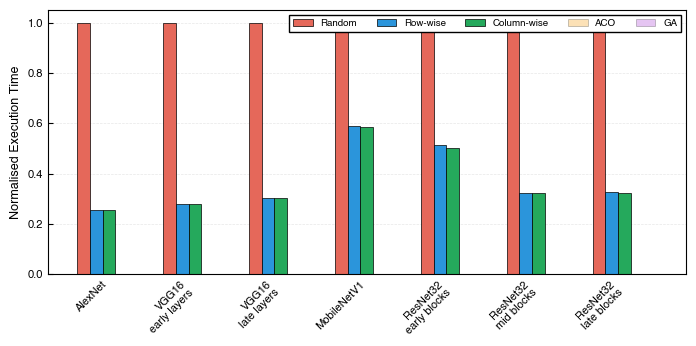

In [44]:
# Generate the mapping comparison plot
fig, ax = plot_mapping_comparison_ieee(
    model_dataframes=model_dataframes_normalised,
    figsize=(7.0, 3.5),
    use_norm=True,
    save_path='../data/mapping_comparison_all_models.png',
    dpi=800
)

plt.show()